# Importing data-science-bowl 2018 dataset

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "/kaggle/input/data-science-bowl-2018/stage1_train.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    #zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall('dataset') 
    print('Done!')

# Importing required modules or libraries

In [ ]:
# importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import cv2
import tensorflow as tf
import keras
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Concatenate
from keras.models import Model


In [ ]:
#seeding
seed = 2019
np.random.seed = seed
tf.seed = seed

In [ ]:
#data generator
class DataGen(keras.utils.Sequence):
    def __init__(self,ids,path,batch_size,image_size):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self,id_name):
        #path
        image_path = os.path.join(self.path,id_name,"images",id_name) + '.png'
        mask_path = os.path.join(self.path,id_name,"masks/")
        all_masks = os.listdir(mask_path)
        
        #reading_images
        try:
            image = cv2.imread(image_path,1)
            image = cv2.resize(image,(self.image_size,self.image_size))
        except Exception as e:
            print(str(e))
        
        mask = np.zeros((self.image_size,self.image_size,1))
        #reading masks
        for name in all_masks:
            try:
                _mask_path = mask_path +name
                _mask_image = cv2.imread(_mask_path,-1)
                _mask_image = cv2.resize(_mask_image,(self.image_size,self.image_size))
                _mask_image = np.expand_dims(_mask_image,axis = -1)
                mask = np.maximum(mask,_mask_image)
            except Exception as e:
                print(str(e))
        
        #normalising
        image = image/255.
        mask = mask/255.
        return image,mask
    
    def __getitem__(self,index):
        if (index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
            
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask = []
        
        for id_name in files_batch:
            _img , _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask = np.array(mask)
        
        return image,mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

# Specify Hyperparameters for networks

In [ ]:

image_size = 128
batch_size = 8
epochs = 10
train_path = "dataset"
train_ids = next(os.walk(train_path))[1]
val_data_size = 10
valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [ ]:
# initialize datagenerator
gen = DataGen(train_ids,train_path,batch_size = batch_size ,image_size = image_size)
x,y = gen.__getitem__(0)
print(x.shape,y.shape)

# Visualing image and mask from dataset

In [ ]:
# visualize dataset
r = np.random.randint(0,len(x)-1)
fig = plt.figure()
fig.subplots_adjust(hspace =0.4 ,wspace =0.4)
ax = fig.add_subplot(1,2,1)
ax.title.set_text('image')
ax.imshow(x[r])
ax = fig.add_subplot(1,2,2)
ax.title.set_text('mask')
ax.imshow(np.reshape(y[r],(image_size , image_size)),cmap = 'gray')


# **Different convolution blocks
**

In [ ]:
# different convolution blocks
# 2d standard_unit for downsampling in all models
def standard_unit(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPooling2D((2,2))(c)
    return c,p

# upsampling_unit combinataion of deconvolution and skip layer
def upsampling_unit(x, skip,filters, kernel_size=(3, 3), padding="same", strides=1):
    us = Conv2DTranspose(filters ,(2,2),strides=(2, 2), padding='same')(x)
    concat = Concatenate()([us,skip])
    c,_ = standard_unit(concat,filters)
    return c

# bottleneck function for unet
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c



# Standard U-Net

**Network architecture for standard unet**
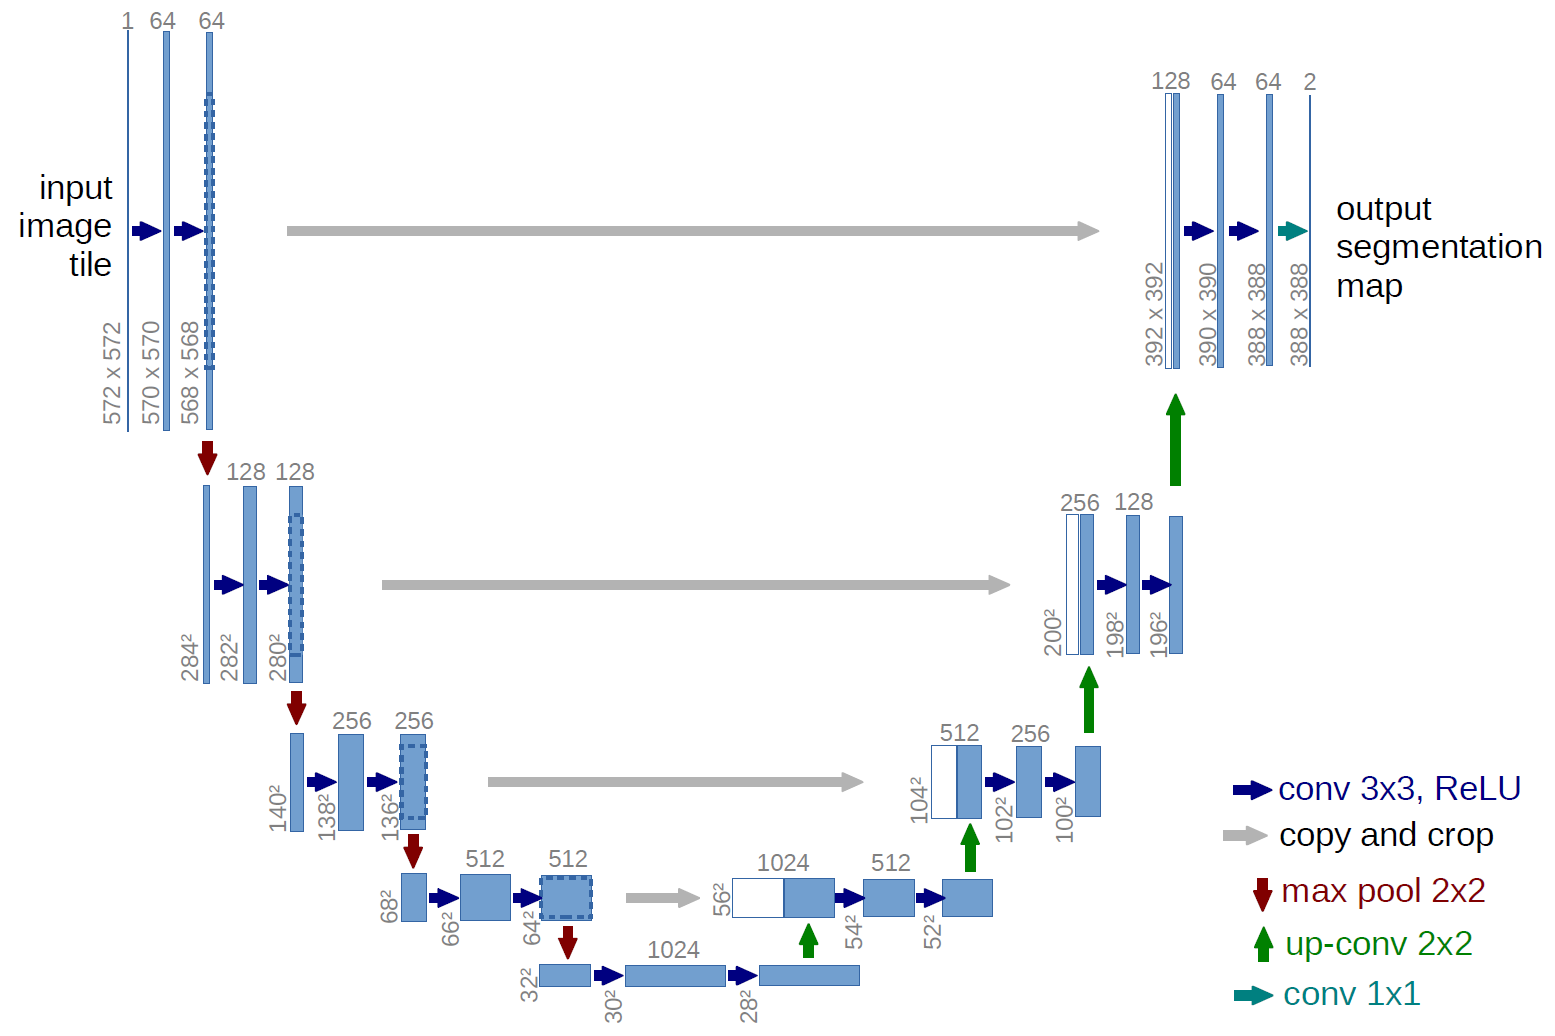

In [ ]:
"""
standard u-net 
"""

# define model for unet segmentation
def UNet(image_row,image_col):
    f = [16, 32, 64, 128, 256]
    inputs = Input((image_row,image_col, 3))
    
    p0 = inputs
    c1, p1 = standard_unit(p0, f[0]) #128 -> 64
    c2, p2 = standard_unit(p1, f[1]) #64 -> 32
    c3, p3 = standard_unit(p2, f[2]) #32 -> 16
    c4, p4 = standard_unit(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = upsampling_unit(bn, c4, f[3]) #8 -> 16
    u2 = upsampling_unit(u1, c3, f[2]) #16 -> 32
    u3 = upsampling_unit(u2, c2, f[1]) #32 -> 64
    u4 = upsampling_unit(u3, c1, f[0]) #64 -> 128
    
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = Model(inputs, outputs)
    return model




# standard W-Unet

In [ ]:
"""
wide unet 
"""

# define wide u-net model
def W_UNet(image_row,image_col):
    #f = [16,32,64,128,256]
    f = [35,70,140,280,560]
    img_input = Input((image_row , image_col ,3))
    
    c11,p1 = standard_unit(img_input,f[0])
    c21,p2 = standard_unit(p1,f[1])
    c31,p3 = standard_unit(p2,f[2])
    c41,p4 = standard_unit(p3,f[3])
    c51,_ = standard_unit(p4 ,f[4])
    
    c42 = upsampling_unit(c51,c41,f[3])
    c33 = upsampling_unit(c42,c31,f[2])
    c24 = upsampling_unit(c33,c21,f[1])
    c15 = upsampling_unit(c24,c11,f[0])
    
    outputs = Conv2D(1,(1,1),activation='sigmoid',padding = 'same',strides =1)(c15)
    
    model = Model(img_input,outputs)
    return model


# standard unet++ or nested net

**Architecture of standard unet++
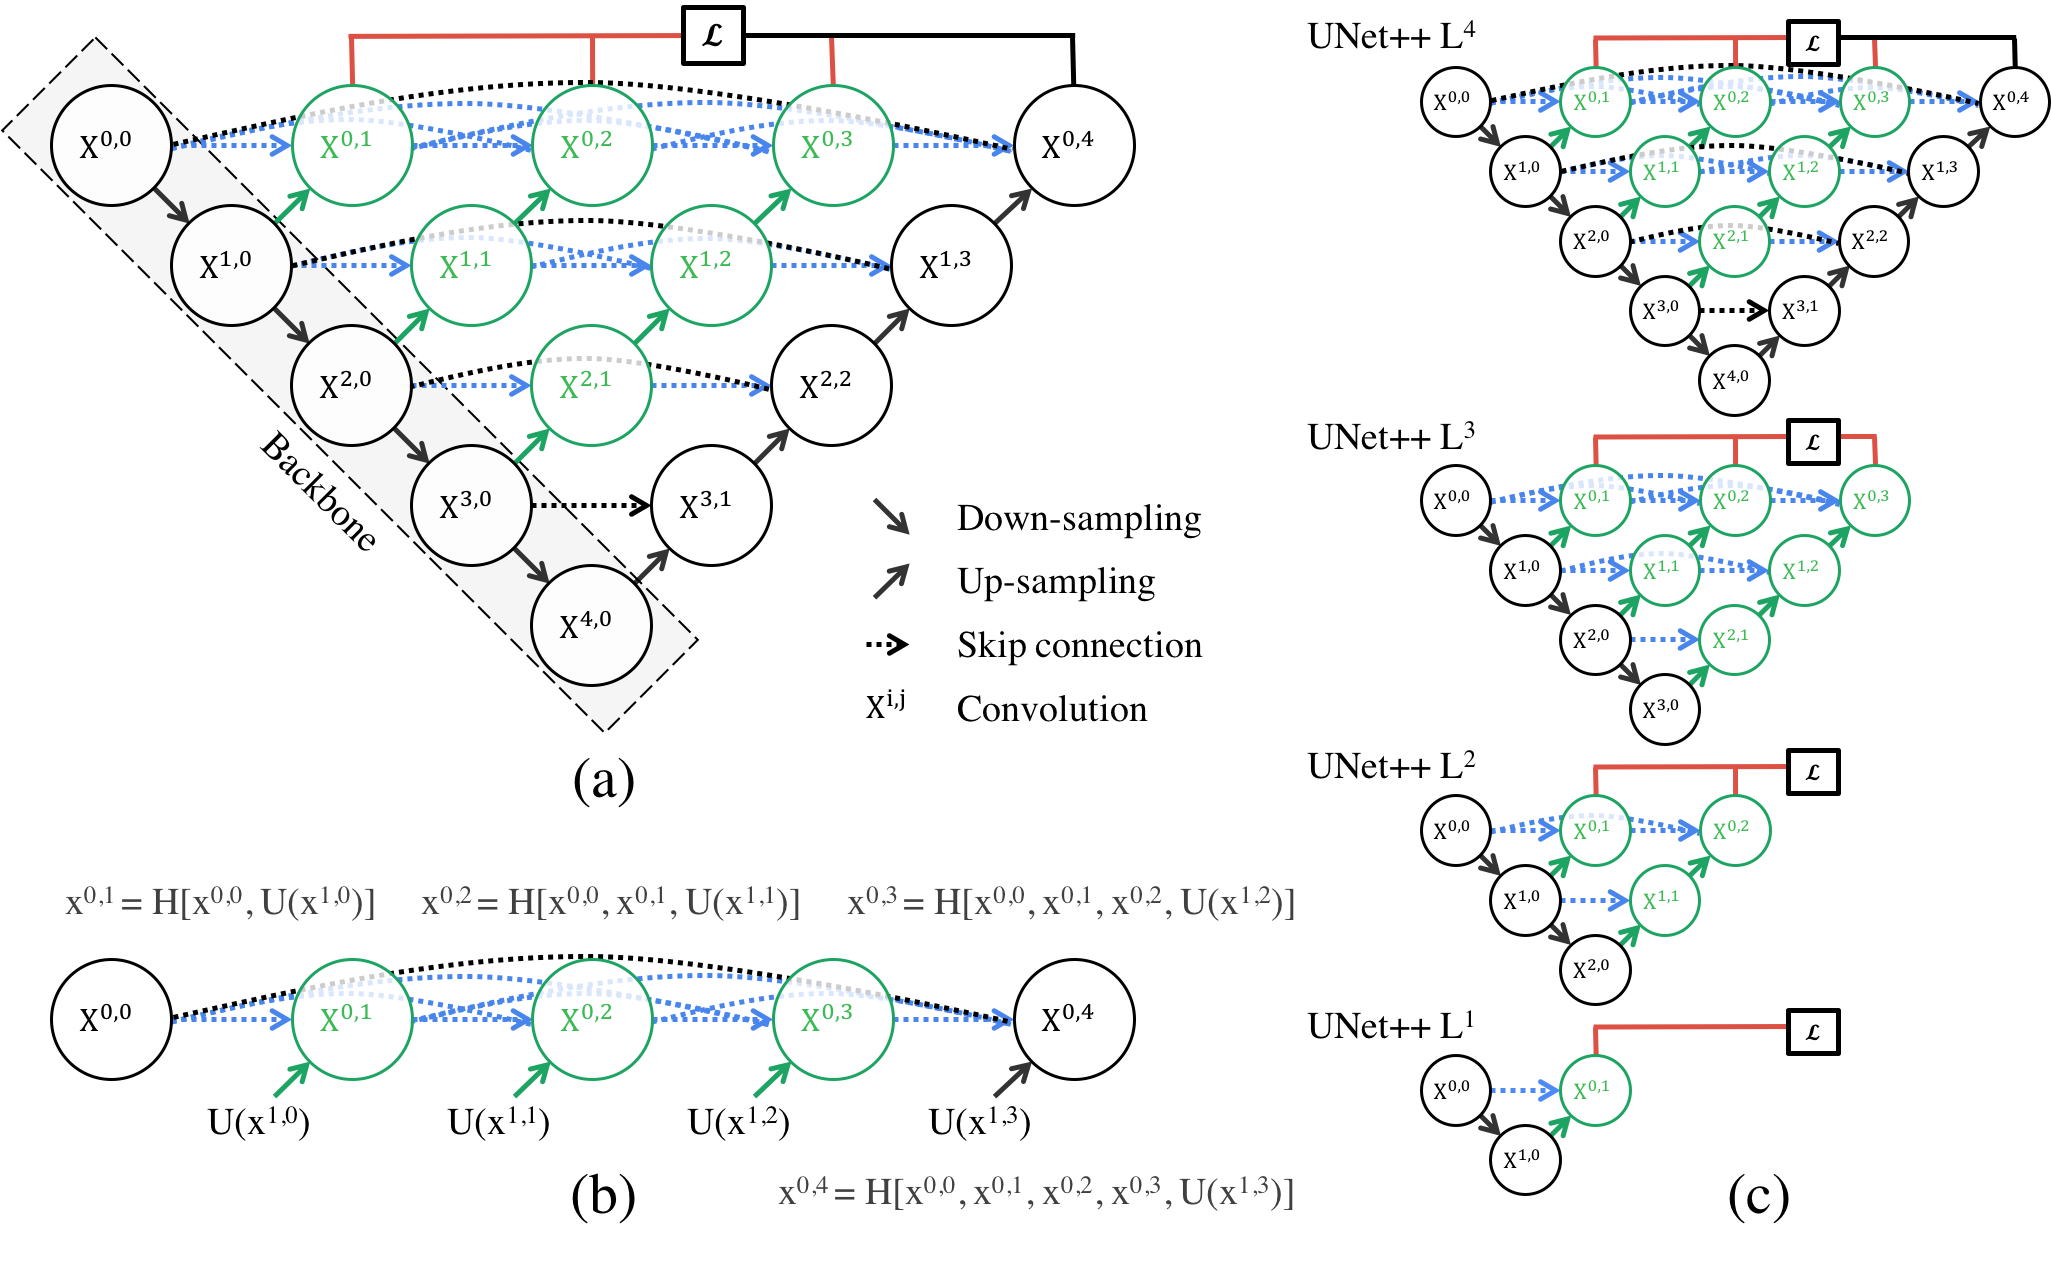

In [ ]:
"""
nested u-net or standard unet++
"""

# define unet++ model
def Nested_Net(image_row,image_col):
    f = [16, 32, 64, 128, 256]
    img_input = Input((image_row,image_col, 3))

    # first downsampling layer
    c11,p1 = standard_unit(img_input,f[0])
    c21,p2 = standard_unit(p1 , f[1])
    c31,p3 = standard_unit(p2,f[2])
    c41,p4 = standard_unit(p3,f[3])
    c51,_ = standard_unit(p4 ,f[4])
    
    u12 = Conv2DTranspose(f[0], (2, 2), strides=(2, 2), padding='same')(c21)
    concat = Concatenate()([u12, c11])
    c12,_ = standard_unit(concat, f[0])

    u22 = Conv2DTranspose(f[1], (2, 2), strides=(2, 2), padding='same')(c31)
    concat = Concatenate()([u22, c21])
    c22,_ = standard_unit(concat, f[1])

    u32 = Conv2DTranspose(f[2], (2, 2), strides=(2, 2), padding='same')(c41)
    concat = Concatenate()([u32, c31])
    c32,_ = standard_unit(concat, f[2])

    u42 = Conv2DTranspose(f[3], (2, 2), strides=(2, 2), padding='same')(c51)
    concat = Concatenate()([u42, c41])
    c42,_ = standard_unit(concat, f[3])
    
    u13 = Conv2DTranspose(f[0], (2, 2), strides=(2, 2), padding='same')(c22)
    concat = Concatenate()([u13, c11,c12])
    c13,_ = standard_unit(concat, f[0])

    u23 = Conv2DTranspose(f[1], (2, 2), strides=(2, 2), padding='same')(c32)
    concat = Concatenate()([u23, c21,c22])
    c23,_ = standard_unit(concat, f[1])

    u33 = Conv2DTranspose(f[2], (2, 2), strides=(2, 2), padding='same')(c42)
    concat = Concatenate()([u33, c31,c32])
    c33,_ = standard_unit(concat, f[2])
    
    u14 = Conv2DTranspose(f[0], (2, 2), strides=(2, 2), padding='same')(c23)
    concat = Concatenate()([u14, c11,c12,c13])
    c14,_ = standard_unit(concat, f[0])

    u24 = Conv2DTranspose(f[1], (2, 2), strides=(2, 2), padding='same')(c33)
    concat = Concatenate()([u24, c21,c22,c23])
    c24,_ = standard_unit(concat, f[1])
    
    u15 = Conv2DTranspose(f[0], (2, 2), strides=(2, 2), padding='same')(c24)
    concat = Concatenate()([u15, c11,c12,c13,c14])
    c15,_ = standard_unit(concat, f[0])
    
    nestnet_output1 = Conv2D(1,(1,1) ,activation= 'sigmoid',padding ='same' ,strides =1)(c12)
    nestnet_output2 = Conv2D(1,(1,1) ,activation= 'sigmoid',padding ='same' ,strides =1)(c13)
    nestnet_output3 = Conv2D(1,(1,1) ,activation= 'sigmoid',padding ='same' ,strides =1)(c14)
    nestnet_output4 = Conv2D(1,(1,1) ,activation= 'sigmoid',padding ='same' ,strides =1)(c15)
    
    model = Model(input = img_input ,output = nestnet_output4)
    return model




# load training and test generators

In [ ]:
train_gen = DataGen(train_ids,train_path,batch_size=batch_size, image_size=image_size)
valid_gen = DataGen(valid_ids,train_path,batch_size=batch_size, image_size=image_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size



# Compiling and training u-net


In [ ]:
model_unet = UNet(128,128)
model_unet.compile(optimizer='adam' ,loss = 'binary_crossentropy',metrics = ['accuracy'])
model_unet.summary()

In [ ]:
# fit to unet
model_unet.fit_generator(train_gen,
                  validation_data = valid_gen,
                  steps_per_epoch = train_steps,
                  validation_steps= valid_steps,
                  epochs = epochs)

# Compiling and training of wide-unet

In [ ]:
model_w_unet = W_UNet(128,128)
model_w_unet.compile(optimizer='adam' ,loss = 'binary_crossentropy',metrics = ['accuracy'])
model_w_unet.summary()

In [ ]:
# fit to wide-unet
model_w_unet.fit_generator(train_gen,
                  validation_data = valid_gen,
                  steps_per_epoch = train_steps,
                  validation_steps= valid_steps,
                  epochs = epochs)

# Compiling and fit to nested_net or unet++

In [ ]:
model_nested_net = Nested_Net(128,128)
model_nested_net.compile(optimizer='adam' ,loss = 'binary_crossentropy',metrics = ['accuracy'])
model_nested_net.summary()

In [ ]:
# fit to nested-net
model_nested_net.fit_generator(train_gen,
                  validation_data = valid_gen,
                  steps_per_epoch = train_steps,
                  validation_steps= valid_steps,
                  epochs = epochs)

# Testing model for different networks

In [ ]:
# testing the model
#model.save_weights('UNet++w.h5')

x,y = valid_gen.__getitem__(1)
result_unet  = model_unet.predict(x)
result_unet = result_unet >0.5


In [ ]:
# testing the model
#model.save_weights('UNet++w.h5')

x,y = valid_gen.__getitem__(1)
result_w_unet  = model_w_unet.predict(x)
result_w_unet = result_w_unet >0.5


In [ ]:
# testing the model
#model.save_weights('UNet++w.h5')

x,y = valid_gen.__getitem__(1)
result_nested_net  = model_nested_net.predict(x)
result_nested_net = result_nested_net >0.5


# Visualing Output

In [ ]:
# visualizing output

fig = plt.figure()
fig.subplots_adjust(hspace =1 ,wspace =1)
ax1 = fig.add_subplot(2,3,1)
ax1.title.set_text('image')
ax1.imshow(x[1])

ax2 = fig.add_subplot(2,3,2)
ax2.title.set_text('mask')
ax2.imshow(np.reshape(y[1]*255,(image_size , image_size)),cmap = 'gray')

ax3 = fig.add_subplot(2, 3, 4)
ax3.title.set_text('U-Net')
ax3.imshow(np.reshape(result_unet[1]*255, (image_size, image_size)), cmap="gray")

ax4 = fig.add_subplot(2, 3,5)
ax4.title.set_text('U-Net')
ax4.imshow(np.reshape(result_w_unet[1]*255, (image_size, image_size)), cmap="gray")

ax5 = fig.add_subplot(2, 3, 6)
ax5.title.set_text('Nested-Net')
ax5.imshow(np.reshape(result_nested_net[1]*255, (image_size, image_size)), cmap="gray")